In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras import layers
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import adam_v2
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import random
from tqdm.notebook import tqdm
import collections
from keras.models import load_model

In [2]:
import module

In [3]:
import importlib
importlib.reload(module)

<module 'module' from 'C:\\Users\\Admin\\Documents\\Anaconda1\\08_random_aug_edge\\module.py'>

In [4]:
df = pd.read_csv('F:/data_edge/3_data/data.csv', header=None)
df = df.sort_values([1, 0])

train = np.array(df[0 : 7000].sample(7000))
train_data = train[:, 2:502] # shape (7000, 500), 100 website, 70 repeat
train_index = train[:, 0] # shape (7000,), 0-99 range, random

test = np.array(df[7000 : 10000].sort_values([0, 1]))
test_data = test[:, 2:502] # shape (3000, 500), 100 website, 70 repeat
test_index = test[:, 0] # shape (3000,), 0-99 range, sequence

In [5]:
test_data_ow = module.load_data_ow('F:/data_edge/3_data/data_ow.csv')

test data ow shape: (1000, 500)


In [6]:
model = load_model('data/model_tcp.h5')

In [7]:
model.evaluate(test_data.astype('float32')/1600, to_categorical(test_index))

94/94 [==============================] - 2s 19ms/step - loss: 0.1871 - accuracy: 0.9667


[0.1870512068271637, 0.9666666388511658]

In [8]:
# WF 无操作

In [9]:
TPR, FPR = module.ow_evaluate(model, test_data, test_data_ow)

32/32 [==============================] - 1s 19ms/step


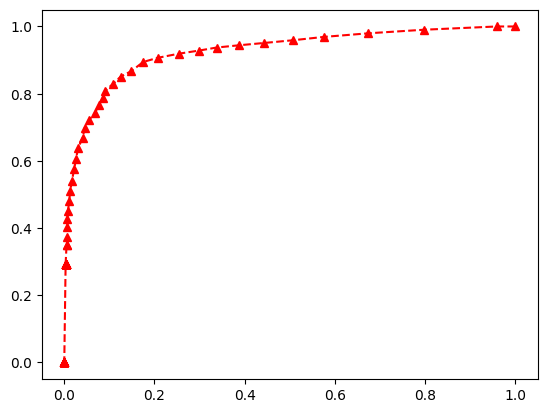

In [10]:
plt.plot(FPR, TPR, 'r^--')

In [11]:
FPR_WF = FPR.copy()
TPR_WF = TPR.copy()

In [12]:
# RPD Insert

In [13]:
def get_data_length(data_vector):
    data_length = 500
    for i in range(500):
        if data_vector[i] == 0:
            data_length = i
            break
    return data_length

def add_noise(data_vector, data_length, count):
    for i in range(count):
        location = random.randint(0, data_length - 1)
        packet = random.randint(-1600, 1600)
        data_vector = np.insert(data_vector, location, packet)
        if data_length < 500:
            data_length += 1
    
    return data_vector[0 : 500]

In [14]:
rate = 0.2
test_data_noise = test_data.copy()
for i in range(3000):
    length = get_data_length(test_data_noise[i])
    test_data_noise[i] = add_noise(test_data_noise[i], length, int(length * rate))

rate = 0.2
test_data_ow_noise = test_data_ow.copy()
for i in range(1000):
    length = get_data_length(test_data_ow_noise[i])
    test_data_ow_noise[i] = add_noise(test_data_ow_noise[i], length, int(length * rate))

In [15]:
TPR, FPR = module.ow_evaluate(model, test_data_noise, test_data_ow_noise)

32/32 [==============================] - 1s 18ms/step


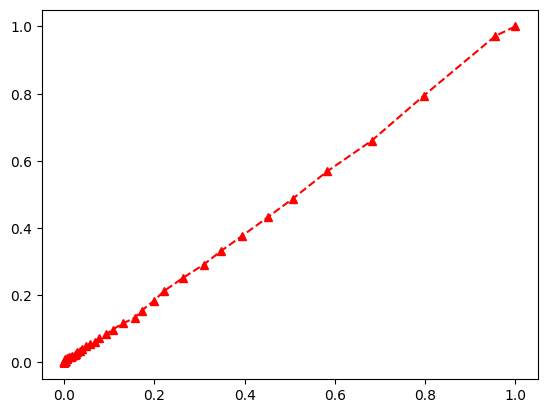

In [16]:
plt.plot(FPR, TPR, 'r^--')

In [17]:
FPR_Insert = FPR.copy()
TPR_Insert = TPR.copy()

In [18]:
# RPD Insert AA

In [19]:
model_aa = load_model('data/model_tcp_aug.h5')
TPR, FPR = module.ow_evaluate(model_aa, test_data_noise, test_data_ow_noise)

32/32 [==============================] - 1s 20ms/step


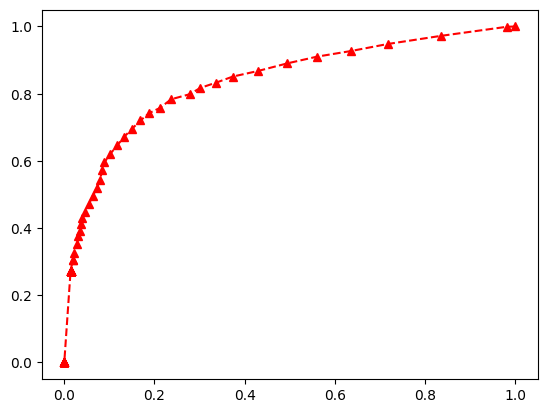

In [20]:
plt.plot(FPR, TPR, 'r^--')

In [21]:
FPR_Insert_AA = FPR.copy()
TPR_Insert_AA = TPR.copy()

In [22]:
# RPD MTU

In [23]:
def get_data_length(data_vector):
    data_length = 500
    for i in range(500):
        if data_vector[i] == 0:
            data_length = i
            break
    return data_length

def add_noise(data_vector, data_length, count):
    lin_num = list(np.linspace(0, data_length - 1, data_length, dtype=int))
    random_num = random.sample(lin_num, count)
    for i in random_num:
        if data_vector[i] > 0:
            data_vector[i] = max(data_vector)
        elif data_vector[i] < 0:
            data_vector[i] = min(data_vector)
    return data_vector

In [24]:
rate = 0.2
test_data_noise = test_data.copy()
for i in range(3000):
    length = get_data_length(test_data_noise[i])
    test_data_noise[i] = add_noise(test_data_noise[i], length, int(length * rate))

rate = 0.2
test_data_ow_noise = test_data_ow.copy()
for i in range(1000):
    length = get_data_length(test_data_ow_noise[i])
    test_data_ow_noise[i] = add_noise(test_data_ow_noise[i], length, int(length * rate))

In [25]:
TPR, FPR = module.ow_evaluate(model, test_data_noise, test_data_ow_noise)

32/32 [==============================] - 1s 19ms/step


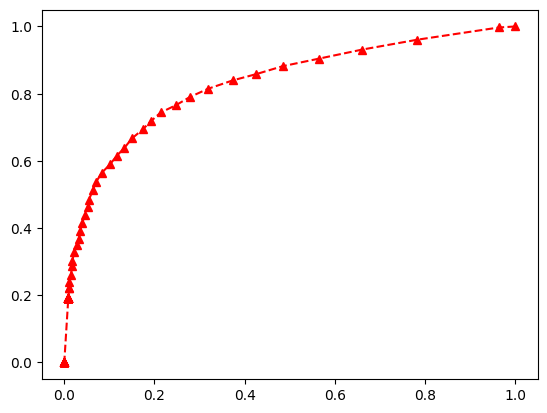

In [26]:
plt.plot(FPR, TPR, 'r^--')

In [27]:
FPR_MTU = FPR.copy()
TPR_MTU = TPR.copy()

In [28]:
# RPD MTU AA

In [29]:
model_aa = load_model('data/model_tcp_mtu_aug.h5')
TPR, FPR = module.ow_evaluate(model_aa, test_data_noise, test_data_ow_noise)

32/32 [==============================] - 1s 19ms/step


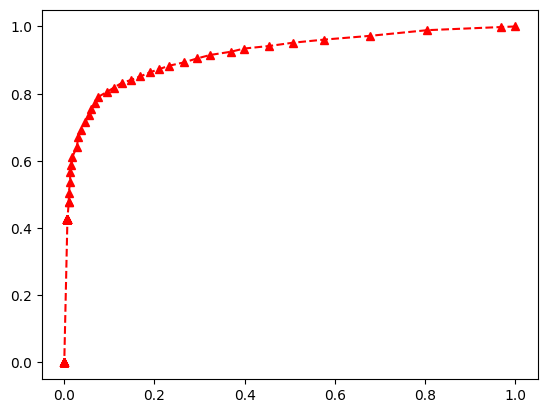

In [30]:
plt.plot(FPR, TPR, 'r^--')

In [31]:
FPR_MTU_AA = FPR.copy()
TPR_MTU_AA = TPR.copy()

In [32]:
# RPD Split

In [33]:
def get_data_length(data_vector):
    data_length = 500
    for i in range(500):
        if data_vector[i] == 0:
            data_length = i
            break
    return data_length

def add_noise(data_vector, data_length, count):
    for i in range(count):
        location = random.randint(0, data_length - 1)
        first = second = 0
        if data_vector[location] > 5:
            first = random.randint(1, data_vector[location] - 1)
            second = data_vector[location] - first
        elif data_vector[location] < -5:
            first = random.randint(data_vector[location] + 1, -1)
            second = data_vector[location] - first
        data_vector[location] = second
        data_vector = np.insert(data_vector, location, first)
        if data_length < 500:
            data_length += 1
    return data_vector[0 : 500]

In [34]:
rate = 0.2
test_data_noise = test_data.copy()
for i in range(3000):
    length = get_data_length(test_data_noise[i])
    test_data_noise[i] = add_noise(test_data_noise[i], length, int(length * rate))

rate = 0.2
test_data_ow_noise = test_data_ow.copy()
for i in range(1000):
    length = get_data_length(test_data_ow_noise[i])
    test_data_ow_noise[i] = add_noise(test_data_ow_noise[i], length, int(length * rate))

In [35]:
TPR, FPR = module.ow_evaluate(model, test_data_noise, test_data_ow_noise)

32/32 [==============================] - 1s 20ms/step


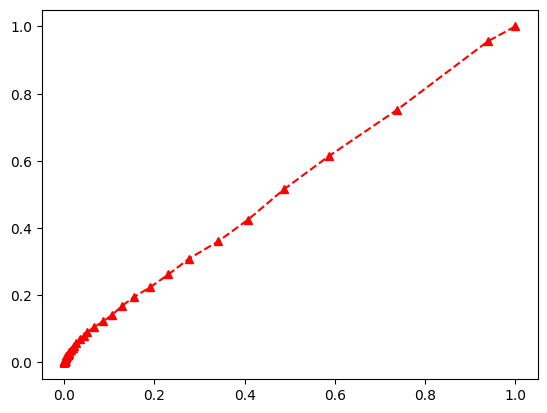

In [36]:
plt.plot(FPR, TPR, 'r^--')

In [37]:
FPR_Split = FPR.copy()
TPR_Split = TPR.copy()

In [38]:
# RPD Split AA

In [39]:
model_aa = load_model('data/model_tcp_split_aug.h5')
TPR, FPR = module.ow_evaluate(model_aa, test_data_noise, test_data_ow_noise)

32/32 [==============================] - 1s 19ms/step


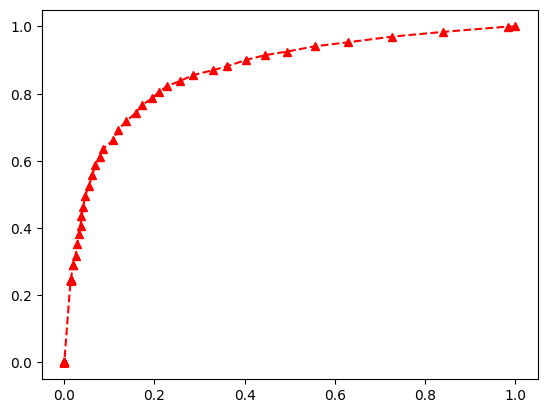

In [40]:
plt.plot(FPR, TPR, 'r^--')

In [41]:
FPR_Split_AA = FPR.copy()
TPR_Split_AA = TPR.copy()

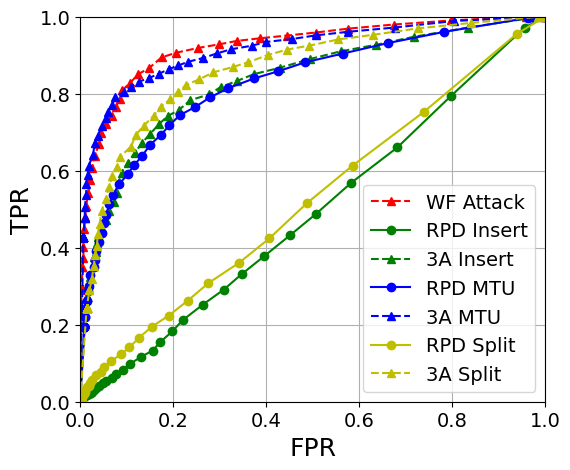

In [43]:
plt.figure(figsize=(6,5))

plt.plot(FPR_WF, TPR_WF, 'r^--')

plt.plot(FPR_Insert, TPR_Insert, 'go-')
plt.plot(FPR_Insert_AA, TPR_Insert_AA, 'g^--')

plt.plot(FPR_MTU, TPR_MTU, 'bo-')
plt.plot(FPR_MTU_AA, TPR_MTU_AA, 'b^--')

plt.plot(FPR_Split, TPR_Split, 'yo-')
plt.plot(FPR_Split_AA, TPR_Split_AA, 'y^--')


plt.legend(['WF Attack', 'RPD Insert', '3A Insert', 'RPD MTU', '3A MTU', 'RPD Split', '3A Split'], fontsize=14)
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.savefig('C:/Users/Admin/Desktop/roc_edge_aa.pdf', bbox_inches = 'tight')